<div style="background-color: #FFDDDD; border-left: 5px solid red; padding: 10px; color: black;">
    <strong>Kernel: Python 3 (ipykernel)
</div>

In [ ]:
!python3 -m pip install -q transformers==4.37.0

In [ ]:
!python3 -m pip install -qU torch==2.0.1 --index-url https://download.pytorch.org/whl/cu118

In [ ]:
!python3 -m pip install -qU bitsandbytes==0.41.0
!python3 -m pip install -qU peft==0.8.1
!python3 -m pip install -qU datasets==2.18.0 
!python3 -m pip install -qU tensorboardX==2.6.2.2
!python3 -m pip install -qU py7zr==0.21.0
!python3 -m pip install -qU einops==0.7.0
!python3 -m pip install -qU sqlparse==0.4.4

# Text to SQL Exploration

This notebook walks you through the process of prototyping with the help of a Text-to-SQL model from HuggingFace hub using transformers API. In the subsequent cells of this notebook we walk you through the process of,
1. Downloading a `defog/sqlcoder-7b-2` model from HF Hub
2. Setting up a `pipeline` for inference using the model in memory
3. Defining a high performance text-to-sql prompt to enable LLM to respond back with SQL queries based on your database schema
4. Executing SQL queries in notebooks using the new built-in Studio SQL feature

In [ ]:
import os
import time
import re
import html
import shutil
import sqlparse
import pandas as pd
import torch
from threading import Thread
from accelerate import Accelerator
import transformers
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM, 
    BitsAndBytesConfig,
    TextIteratorStreamer
)
from peft import (
    prepare_model_for_kbit_training, 
    LoraConfig, 
    get_peft_model, 
    AutoPeftModelForCausalLM
)
import sqlparse
import textwrap
import sagemaker
import plotly.io as pio
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
import requests
from bs4 import BeautifulSoup
from IPython.display import clear_output, display, HTML
from sagemaker.model import Model

We're going to load 2 notebook magic commands to use inside this notebook,
1. `%%sm_sql` is enabled by loading `amazon_sagemaker_sql_magic`
2. `%%ai` is enabled by loading `jupyter_ai_magics`

In [ ]:
%load_ext amazon_sagemaker_sql_magic
%load_ext jupyter_ai_magics

In [ ]:
sess = sagemaker.Session()
s3_bucket_name = sess.default_bucket() 
role = sagemaker.get_execution_role()

## Download SQL Reserved Keywords

To differentiate between SQL reserved words vs variables we need a reference list of global SQL keyword values.

In [ ]:
def fetch_and_parse_sql_reserved_keywords(url):
    # Fetch the HTML content from the URL
    response = requests.get(url)
    html_content = response.text
    soup = BeautifulSoup(html_content, 'html.parser')
    table = soup.find('table')
    rows = table.find_all('tr')
    table_data = []
    for row in rows:
        cells = row.find_all(['td', 'th'])  # Adjust based on your table structure
        row_data = [cell.text.strip() for cell in cells]
        table_data.append(row_data)
    return pd.DataFrame(table_data).iloc[:, 0].tolist()[1:]

In [ ]:
url = 'https://en.wikipedia.org/wiki/List_of_SQL_reserved_words'
all_reserved_sql_kw = fetch_and_parse_sql_reserved_keywords(url)

In [ ]:
print(f"Example of SQL reserved keywords found: {all_reserved_sql_kw[:5]}")

## Download Model and Tokenizer

Let's download model weights and tokenizer artifacts from HuggingFace hub using `AutoModelForCausalLM` class.

We're going to download `defog/sqlcoder-7b-2` and pin the model to our local GPU in `bfloat16` format. To understand more about different `torch_dtype` refer to image below.

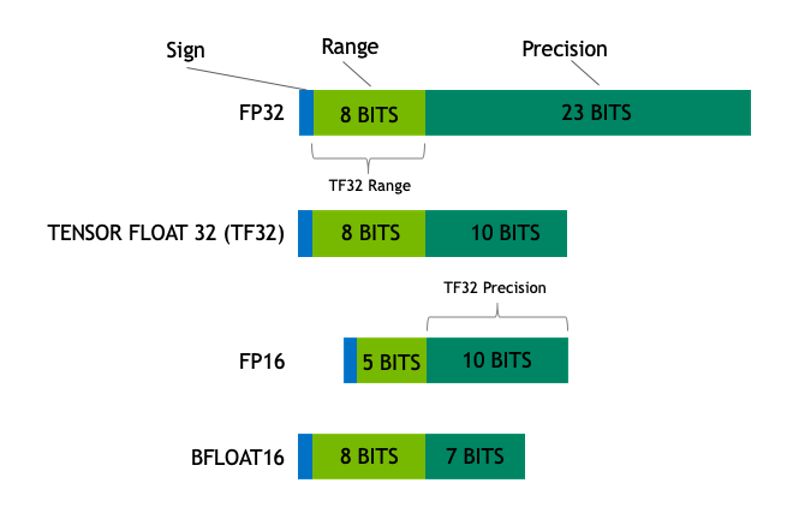

In [ ]:
model_id = "defog/sqlcoder-7b-2"
model = AutoModelForCausalLM.from_pretrained(
    model_id, 
    device_map="auto",
    torch_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

## Prompt

SQLCoder model was fine-tuned on a prompt format as shown below, we're going to use this prompt format to allow our SQL model to convert natural language text to SQL

```
### Task
Generate a SQL query to answer [QUESTION]{user_question}[/QUESTION]

### Instructions
- If you cannot answer the question with the available database schema, return 'I do not know'

### Database Schema
The query will run on a database with the following schema:
{table_metadata_string_DDL_statements}

### Answer
Given the database schema, here is the SQL query that 
 [QUESTION]
    {user_question}
 [/QUESTION]

[SQL]
```

In [ ]:
prompt = """### Task
Generate a SQL query to answer [QUESTION]{question}[/QUESTION]

### Instructions
- If you cannot answer the question with the available database schema, return 'I do not know'
- You need to structure all SQL queries with Database, Schema and Table name like this "WWSOSAGEMAKERDEMODATABASE1"."AIRLINESDEMODATABASE"."<table>"."<column>"
- All Databasebases, Schemas, Tables and Columns will need to be in quotes like "..."
- If the question contains airport as codes like "IAD" or "XYZ" you need to use src_airport."Airport Code" 
- If the user provides full names of the Airports like "John F Kennedy", "Dallas Airport" then use ILIKE or LIKE to filter for result
- Here are some previous Question and SQL Answer pairs below that needs to be used as reference,

    How many unique airports are in the United States?
    
    SELECT COUNT(DISTINCT "WWSOSAGEMAKERDEMODATABASE1"."AIRLINESDEMODATABASE"."src_airport"."AirportID")
    FROM "WWSOSAGEMAKERDEMODATABASE1"."AIRLINESDEMODATABASE"."src_airport"
    JOIN "WWSOSAGEMAKERDEMODATABASE1"."AIRLINESDEMODATABASE"."src_country" 
    ON "WWSOSAGEMAKERDEMODATABASE1"."AIRLINESDEMODATABASE"."src_airport"."CountryID" = "WWSOSAGEMAKERDEMODATABASE1"."AIRLINESDEMODATABASE"."src_country"."CountryID"
    WHERE "WWSOSAGEMAKERDEMODATABASE1"."AIRLINESDEMODATABASE"."src_country"."Country Name" = 'United States'
    
    
    How many airports are located in Canada?
    
    SELECT COUNT(DISTINCT "WWSOSAGEMAKERDEMODATABASE1"."AIRLINESDEMODATABASE"."src_airport"."AirportID")
    FROM "WWSOSAGEMAKERDEMODATABASE1"."AIRLINESDEMODATABASE"."src_airport"
    JOIN "WWSOSAGEMAKERDEMODATABASE1"."AIRLINESDEMODATABASE"."src_country" 
    ON "WWSOSAGEMAKERDEMODATABASE1"."AIRLINESDEMODATABASE"."src_airport"."CountryID" = "WWSOSAGEMAKERDEMODATABASE1"."AIRLINESDEMODATABASE"."src_country"."CountryID"
    WHERE "WWSOSAGEMAKERDEMODATABASE1"."AIRLINESDEMODATABASE"."src_country"."Country Name" = 'Canada'
    
    How many flights were delayed on Jan 10 2022?
    
    SELECT COUNT(*)
    FROM "WWSOSAGEMAKERDEMODATABASE1"."AIRLINESDEMODATABASE"."flight_departure_data"
    WHERE "WWSOSAGEMAKERDEMODATABASE1"."AIRLINESDEMODATABASE"."flight_departure_data"."Departure Date" = '2022-01-10'
    AND "WWSOSAGEMAKERDEMODATABASE1"."AIRLINESDEMODATABASE"."flight_departure_data"."Flight Status" = 'Delayed'


### Database Schema
This query will run on a database whose schema is represented in this string:

CREATE SCHEMA WWSOSAGEMAKERDEMODATABASE1;

USE WWSOSAGEMAKERDEMODATABASE1;

CREATE TABLE src_gender (
  Gender VARCHAR(255), -- Person's gender either Male or Female
  GenderID INTEGER PRIMARY KEY -- Unique ID for each Gender
);

CREATE TABLE src_country (
  `Airport Country Code` VARCHAR(255), -- 2 or 3 letter country code for Country used by Airlines ex: United States is US or Canada is CA
  `Country Name` VARCHAR(255), -- Full country name ex: 'United States' or 'Canada'
  Continents VARCHAR(255), -- Continent where this country is located, ex: 'North America' or 'South America'
  CountryID INTEGER PRIMARY KEY -- Unique ID for each Country
);

CREATE TABLE src_passengers (
  `Passenger ID` VARCHAR(255), -- Random hash assigned to a Passenger in lieu of First and Last Name
  Age INTEGER, -- Age of the passenger 
  Nationality VARCHAR(255), -- Nationality of the Passenger that matches with `src_country`.`Country Name`
  FOREIGN KEY (GenderID) REFERENCES src_gender(GenderID), -- GenderID is supplied 
  PassID INTEGER PRIMARY KEY, --  Unique ID for passengers
);

CREATE TABLE src_airport (
  `Airport Name` VARCHAR(255), -- Full name of the airport
  `Airport Continent` VARCHAR(255), -- 3 to 4 letter code for Continent where the Airport is located ex: North America is NAM
  `Airport Code` VARCHAR(255), -- 3 to 4 letter code for Airport ex: Washington DC is IAD
  AirportID INTEGER PRIMARY KEY, -- Unique ID for airport
  FOREIGN KEY (CountryID) REFERENCES src_country(CountryID) -- CountryID is supplied 
);

CREATE TABLE flight_departure_data (
  `Departure Date` VARCHAR(255), -- Departure Date in YYYY-MM-DD HH:MM:SS format
  `Pilot Name` VARCHAR(255), -- Name of the Pilot flying the plane
  `Flight Status` VARCHAR(255), -- Flight status 'On Time', 'Delayed' or 'Cancelled'
  FOREIGN KEY (GenderID) REFERENCES src_gender(GenderID), -- GenderID is supplied
  FOREIGN KEY (PassID) REFERENCES src_passengers(PassID), -- PassID is supplied
  FOREIGN KEY (AirportID) REFERENCES src_airport(AirportID) -- AirportID is supplied
);


-- flight_departure_data.GenderID can be joined with src_gender.GenderID
-- flight_departure_data.PassID can be joined with src_passengers.PassID
-- flight_departure_data.AirportID can be joined with src_airport.AirportID
-- src_passengers.GenderID can be joined with src_gender.GenderID
-- src_airport.CountryID can be joined with src_country.CountryID

### Answer
Given the database schema, here is the SQL query that answers [QUESTION]{question}[/QUESTION]
[SQL]
"""

### Write Prompt File to Disk and then S3

In [ ]:
# ensure this is the same name as the Glue Connection for the database you are running your queries against
db_name_glue_connection = "Airlines_Dataset" 

In [ ]:
# write prompt file to disk
local_db_prompt_dir = "./database-prompts"
os.makedirs(local_db_prompt_dir, exist_ok=True)
local_db_promp_filepath = os.path.join(local_db_prompt_dir, f"{db_name_glue_connection}.prompt")
with open(local_db_promp_filepath, "w") as _file:
    _file.write(prompt)

In [ ]:
db_prompt_s3_uri = f"s3://{s3_bucket_name}/database-prompts"
sagemaker.s3.S3Uploader.upload(local_db_promp_filepath, db_prompt_s3_uri)

In [ ]:
streamer = TextIteratorStreamer(
    tokenizer=tokenizer, 
    timeout=240.0, 
    skip_prompt=True, 
    skip_special_tokens=True
)


def llm_generate_query(user_question):
    
    updated_prompt = prompt.format(question=user_question)
    inputs = tokenizer(updated_prompt, return_tensors="pt").to("cuda")
    return model.generate(
        **inputs,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
        max_new_tokens=1024,
        do_sample=False,
        num_beams=1, 
        streamer=streamer,
    )

def plotly_table(df):
    column_values = [df[c] for c in df.columns.values]
    fig = go.Figure(data=[go.Table(
        header=dict(values=list(df.columns),
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=column_values,
                   fill_color='lavender',
                   align='left'))
    ])
    
    return fig
    
def pretty_print_sql(sql):
    # List of SQL reserved keywords to highlight
    keywords = all_reserved_sql_kw
    
    # Wrap all words in <span> tags with purple color
    # This regex matches any word and wraps it with the purple span, excluding those already in a span (like reserved keywords)
    formatted_sql = re.sub(r"\b(\w+)\b", r"<span style='color: purple;'>\1</span>", sql)

    # Highlight reserved keywords by wrapping them in <span> tags with blue color
    for keyword in keywords:
        formatted_sql = re.sub(f"(<span style='color: purple;'>)({keyword})(</span>)", 
                               r"<span style='color: blue;'><b>\2</b></span>", 
                               formatted_sql, flags=re.IGNORECASE)

    # Replace line breaks and indentations for HTML display
    formatted_sql = formatted_sql.replace("\n", "<br>").replace("    ", "&nbsp;"*4)
    formatted_sql = sqlparse.format(formatted_sql, reindent=True, keyword_case='upper')

    # Use the <pre> tag for preformatted text with a monospace font
    display(HTML(f"<pre style='background-color: #ffefdb; padding: 10px;'>{formatted_sql}</pre>"))


def stream_print_sql_query(user_question):
    t1 = Thread(
        target=llm_generate_query, 
        args=(user_question,)
    )
    t1.start()
    
    partial_text = f"""%%sm_sql --metastore-id {db_name_glue_connection} """+ """--metastore-type GLUE_CONNECTION --output '{"format": "DATAFRAME", "dataframe_name": "df_sample"}' \n\n"""
    for new_text in streamer:  
        partial_text += new_text
        clear_output(wait=True)  
        pretty_print_sql(partial_text)  
        time.sleep(0.1)  


We define a few functions to enable streaming of SQL generated by the model along with some plotting helper functions.

## Examples of Natural Language Queries

### NLQuery 1

In [ ]:
stream_print_sql_query(
    user_question="Provide a count by airport for the number of flights delayed or cancelled between Jan and November of 2022 for flights flying out of airports DCA, JFK and DFW."
)

In [ ]:
df_sample

In [ ]:
fig = px.bar(
    df_sample, 
    x='Airport Code', 
    y='FLIGHT_COUNT',
    title="Flights Delayed or Cancelled by Airport"
)
fig.update_layout(
    xaxis=dict(
        showgrid=False,
        showline=True,
        linecolor='rgb(102, 102, 102)',
        tickfont_color='rgb(102, 102, 102)',
        tickcolor='rgb(102, 102, 102)',
    ),
    margin=dict(l=140, r=40, b=50, t=80),
    legend=dict(
        font_size=10,
        yanchor='middle',
        xanchor='right',
    ),
    width=800,
    height=600,
    paper_bgcolor='white',
    plot_bgcolor='white',
    hovermode='closest',
)
iplot(fig)

### NLQuery 2

In [ ]:
stream_print_sql_query(
    user_question="Give me the top 10 airports with airport names and codes with the most flight departures On Time?"
)

In [ ]:
df_sample

In [ ]:
iplot(plotly_table(df_sample))

In [ ]:
fig = px.scatter(
    df_sample,
    y="Airport Name",
    x="NUM_DEPARTURES",
    title='Top 10 Airports with Departures on Time'
)

fig.update_traces(
    mode='markers', 
    marker=dict(line_width=1, symbol='circle', size=12)
)

fig.update_layout(
    xaxis=dict(
        showgrid=False,
        showline=True,
        linecolor='rgb(102, 102, 102)',
        tickfont_color='rgb(102, 102, 102)',
        showticklabels=True,
    ),
    margin=dict(l=140, r=40, b=50, t=80),
    legend=dict(
        font_size=10,
        yanchor='middle',
        xanchor='right',
    ),
    width=800,
    height=600,
    paper_bgcolor='white',
    plot_bgcolor='white',
    hovermode='closest',
)
fig.show()

### NLQuery 3

In [ ]:
stream_print_sql_query(
    user_question="How many airports are there in the United States, Canada and Mexico?"
)

In [ ]:
df_sample

### NLQuery 4

In [ ]:
stream_print_sql_query(
    user_question="Give me a list of countries and the count of flights that departed 'On Time' between the months of Januray 2022 and April 2022?"
)

In [ ]:
df_sample

# Save Model Weights and Tokenizers

Let's save model weights and tokenizer artifacts to disk and move them to S3 to prevent DJL serving from downloading artifacts repeatedly from HFHub.

In [ ]:
local_model_path = "./sqlcoder-7b-instruct"

In [ ]:
_ = model.save_pretrained(local_model_path)
_ = tokenizer.save_pretrained(local_model_path)

## Push Weights and Tokenizer to S3

In [ ]:
model_s3_prefix = "sqlcoder-7b-instruct"
meta_model_s3_prefix = "sqlcoder-7b-instruct-meta-model"

In [ ]:
pretrained_s3_model_uri = f"s3://{s3_bucket_name}/{model_s3_prefix}"

In [ ]:
sagemaker.s3.S3Uploader.upload(
    local_model_path, 
    pretrained_s3_model_uri
)

## Prepare Meta Model

Let's create a meta model with the following files,

```
./deepspeed-djl-serving-7b/serving.properties
./deepspeed-djl-serving-7b/model.py
./deepspeed-djl-serving-7b/requirements.txt
```

- model.py: defines the inference input/output logic 
- serving.properties: defines runtime global configurations
- requirements.txt: additional modules to download into container for inference

In [ ]:
meta_model_filename = "deepspeed-djl-serving-7b"
os.makedirs(f"./{meta_model_filename}", exist_ok=True)

In [ ]:
# create and write serving properties file
serving_properties = textwrap.dedent(f"""
engine = DeepSpeed
option.tensor_parallel_degree = 1
option.s3url = {pretrained_s3_model_uri}
""").strip()

In [ ]:
with open(os.path.join(f"./{meta_model_filename}", "serving.properties"), "w") as prop_file:
    prop_file.write(serving_properties)

In [ ]:
print(f"Replace bucket name from `obj = s3.Object(sag...`  with --> {s3_bucket_name}")

In [ ]:
%%writefile {meta_model_filename}/model.py
import copy
import sqlparse
import boto3
from djl_python import Input, Output
import os
import torch
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
from typing import Any, Dict, Tuple
import deepspeed
import warnings
import tarfile

predictor = None
prompt_for_db_dict_cache = {}

def download_prompt_from_s3(prompt_filename):

    print(f"downloading prompt file: {prompt_filename}")
    s3 = boto3.resource('s3')
    
    obj = s3.Object("sagemaker-us-east-2-968192116650", f"database-prompts/{prompt_filename}")
    file_content = obj.get()['Body'].read().decode('utf-8')

    print(f"downloaded prompt file: {prompt_filename}!")

    return file_content


def get_model(properties):
    
    local_rank = int(os.getenv("LOCAL_RANK", "0"))
    cwd = properties["model_id"]

    print(cwd, os.listdir(cwd))
    
    print(f"Loading model from {cwd}")
    model = AutoModelForCausalLM.from_pretrained(
        cwd, 
        low_cpu_mem_usage=True, 
        torch_dtype=torch.bfloat16
    )
    model = deepspeed.init_inference(
        model, 
        mp_size=properties["tensor_parallel_degree"]
    )
    
    print(f"Loading tokenizer from {cwd}")
    tokenizer = AutoTokenizer.from_pretrained(cwd)
    generator = pipeline(
        task="text-generation", 
        model=model, 
        tokenizer=tokenizer, 
        device=local_rank,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
    )
    return generator


def handle(inputs: Input) -> None:
    global predictor
    if not predictor:
        predictor = get_model(inputs.get_properties())

    if inputs.is_empty():
        # Model server makes an empty call to warmup the model on startup
        return None

    data = inputs.get_as_json()
    
    text = data["inputs"]
    generation_kwargs = data["parameters"]
    prompt_for_db_key = data["db_prompt"]

    if prompt_for_db_key not in list(prompt_for_db_dict_cache.keys()):
        prompt_for_db_dict_cache[prompt_for_db_key] = download_prompt_from_s3(prompt_for_db_key)
    else:
        print(f"{prompt_for_db_key} found in cache, {prompt_for_db_dict_cache.keys()}!")
    
    sample_prompt = copy.copy(prompt_for_db_dict_cache[prompt_for_db_key])
    sample_prompt = sample_prompt.format(question=text)
    
    outputs = predictor(sample_prompt, **generation_kwargs)
    result = outputs # [{"generated_text": outputs}]
    result = result[0]['generated_text'].strip().replace(';', '')
    result = sqlparse.format(result, reindent=True, keyword_case='upper')
    result = f"""%%sm_sql --metastore-id {prompt_for_db_key.split('.')[0]} --metastore-type GLUE_CONNECTION\n\n{result}\n"""
    result = [{'generated_text': result}]
    
    return Output().add(result)

In [ ]:
%%writefile {meta_model_filename}/requirements.txt
boto3
sqlparse

In [ ]:
!rm -rf ./{meta_model_filename}/.ipynb_checkpoints/

In [ ]:
os.system(f"tar czvf {meta_model_filename}.tar.gz ./{meta_model_filename}/")

# Deploy

Now, let's deploy the model as a SageMaker endpoint using DJL serving image

In [ ]:
inference_image_uri = sagemaker.image_uris.retrieve(
    framework="djl-deepspeed", 
    region="us-east-2", 
    version="0.25.0"
)
print(f"Image going to be used is ---- > {inference_image_uri}")

In [ ]:
code_artifact = sess.upload_data(f"{meta_model_filename}.tar.gz", s3_bucket_name, meta_model_s3_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {code_artifact}")

In [ ]:
sm_model_name = "sqlcoder-7b-deepspeed"
instance_type = "ml.g5.2xlarge"

In [ ]:
sql_model = Model(
    sagemaker_session=sess,
    image_uri=inference_image_uri,
    model_data=code_artifact,
    role=role,
    name=sm_model_name,
)

In [ ]:
endpoint_name = f"{sm_model_name}-endpoint"
print(f"Deploying model with endpoint name {endpoint_name}")
sql_model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    endpoint_name=endpoint_name,
    volume_size_in_gb=200,
    container_startup_health_check_timeout=600,
    wait=True, # <-- Set to True, if you would prefer to wait for the endpoint to spin up
)

## Integrate with Jupyter AI

In [ ]:
%reload_ext jupyter_ai_magics

In [ ]:
%%ai sagemaker-endpoint:sqlcoder-7b-deepspeed-ep-endpoint --region-name=us-east-2 --request-schema={"inputs":"<prompt>","parameters":{"temperature":0.1,"top_p":0.2,"max_new_tokens":1024,"return_full_text":false},"db_prompt":"Airlines_Dataset.prompt"} --response-path=[0].generated_text -f code
Provide a count by airport for the number of flights delayed or cancelled between Jan and November of 2022 for flights flying out of airports DCA, JFK and DFW.

In [ ]:
%%ai sagemaker-endpoint:sqlcoder-7b-deepspeed-ep-endpoint --region-name=us-east-2 --request-schema={"inputs":"<prompt>","parameters":{"temperature":0.1,"top_p":0.2,"max_new_tokens":1024,"return_full_text":false},"db_prompt":"Airlines_Dataset.prompt"} --response-path=[0].generated_text -f code
Give me the top 10 airports with airport names and codes with the most flight departures On Time?